In [0]:
!pip install tensorflow==2.0.0-beta

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, utils, Model
from tensorflow.keras import layers, utils, Model
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Add, Activation, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, AveragePooling2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [0]:
class GoogleNet():

    def __init__(self, kernel_initializer, kernel_regularizer, gamma_initializer, dropout, epsilon, weight_decay, momentum):

        self.kernel_regularizer = kernel_regularizer
        self.kernel_initializer = kernel_initializer
        self.gamma_initializer = gamma_initializer
        self.dropout = dropout
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.momentum = momentum
    
    def auxiliary_block(self, x, name):
      
        avg_pool = AveragePooling2D((5, 5), strides=3)(x)
        cnv = Conv2D(128, (1,1), padding='same', activation='relu')(avg_pool)
        flt = Flatten()(cnv)
        dense = Dense(1024, activation='relu')(flt)
        dense_drpt = Dropout(self.dropout)(dense)  
        auxiliary_out = Dense(1000, activation='softmax', name='auxiliary_out'+name)(dense_drpt)

        return auxiliary_out


    def inception_block(self, x, f_1x1, f_3x3_red, f_3x3, f_5x5_red, f_5x5, f_pool, name):

        conv1_1x1 = Conv2D(f_1x1, (1,1), padding='same', 
                           kernel_regularizer=l2(self.kernel_regularizer),
                           name=name+"_conv1_1x1")(x)
        conv2_3x3_red = Conv2D(f_3x3_red, (1, 1), padding='same', 
                               kernel_regularizer=l2(self.kernel_regularizer), 
                               name=name+"_conv2_3x3_red")(x)
        conv2_3x3 = Conv2D(f_3x3, (3,3), padding='same', 
                           kernel_regularizer=l2(self.kernel_regularizer), 
                           name=name+"_conv2_3x3")(conv2_3x3_red)
        conv2_5x5_red = Conv2D(f_5x5_red, (1, 1), padding='same', 
                               kernel_regularizer=l2(self.kernel_regularizer), 
                               name=name+"_conv2_5x5_red")(x)
        conv2_5x5 = Conv2D(f_5x5, (5,5), padding='same', 
                           kernel_regularizer=l2(self.kernel_regularizer), 
                           name=name+"_conv2_5x5")(conv2_5x5_red)
        max_pool = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
        conv_1x1 = Conv2D(f_pool, (1, 1), padding='same', activation='relu', 
                          kernel_regularizer=l2(self.kernel_regularizer), 
                          name=name+"_conv_1x1")(max_pool)

        output = concatenate([conv1_1x1, conv2_3x3, conv2_5x5, conv_1x1], axis=3, name=name)
    
        return output


    def build_model(self, input_dim):
         
        conv1_7x7 = Conv2D(filters=64, kernel_size=(7, 7), padding='same', strides = (2,2), 
                           activation="relu", name='conv1_7x7')(input_dim)
        max_pool_1 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same", 
                                  name='max_pool_1')(conv1_7x7)
        inc_lrn_1 = tf.nn.local_response_normalization(max_pool_1, name="inc_lrn_1")

        conv_2a_3x3 = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', 
                             name='conv_2a_3x3')(inc_lrn_1)
        conv2_3x3 = Conv2D(192, (3,3), padding='same', name='conv_2b_3x3', 
                           kernel_regularizer=l2(self.kernel_regularizer), strides = 1, 
                           use_bias=False)(conv_2a_3x3)
        max_pool_2 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), 
                                  padding="same", name='max_pool_2')(conv2_3x3)

        inception_3a = self.inception_block(max_pool_2, f_1x1=64, f_3x3_red=96,
                          f_3x3=128, f_5x5_red=16, f_5x5=32, f_pool=32, name='incept_3a')
        inception_3b = self.inception_block(inception_3a, f_1x1=128, f_3x3_red=128, 
                          f_3x3=192, f_5x5_red=32, f_5x5=96, f_pool=64, name='incept_3b')
        max_pool_3 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same", 
                                  name='max_pool_3')(inception_3b)

        inception_4a = self.inception_block(max_pool_3, f_1x1=192, f_3x3_red=96, 
                                            f_3x3=208, f_5x5_red=16, f_5x5=48, 
                                            f_pool=64, name='incept_4a')
        aux_4a = self.auxiliary_block(inception_4a,"_4a")
        inception_4b = self.inception_block(inception_4a, f_1x1=160, f_3x3_red=112, 
                                            f_3x3=224, f_5x5_red=24, f_5x5=64, 
                                            f_pool=64, name='incept_4b')
        inception_4c = self.inception_block(inception_4b, f_1x1=128, f_3x3_red=128, 
                                            f_3x3=256, f_5x5_red=24, f_5x5=64, 
                                            f_pool=64, name='incept_4c')
        inception_4d = self.inception_block(inception_4c, f_1x1=112, f_3x3_red=144, 
                                            f_3x3=288, f_5x5_red=32, f_5x5=64, 
                                            f_pool=64, name='incept_4d')
        aux_4d = self.auxiliary_block(inception_4d,"_4d")
        inception_4e = self.inception_block(inception_4d, f_1x1=256, f_3x3_red=160, 
                                            f_3x3=320, f_5x5_red=32, f_5x5=128, 
                                            f_pool=128, name='incept_4e')

        max_pool_4 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same", 
                                  name='max_pool_4')(inception_4e)
        inception_5a = self.inception_block(max_pool_4, f_1x1=256, f_3x3_red=160, 
                                            f_3x3=320, f_5x5_red=32, f_5x5=128, 
                                            f_pool=128, name='incept_5a')
        inception_5b = self.inception_block(inception_5a, f_1x1=384, f_3x3_red=192, 
                                            f_3x3=384, f_5x5_red=48, f_5x5=128, 
                                            f_pool=128, name='incept_5b')

        avg_pool = AveragePooling2D(pool_size=(7, 7), strides=(7, 7), 
                              padding="valid", name="avg_pool_1")(inception_5b)
        dropout = Dropout((0.4))(avg_pool)
        linear = Dense(1000, activation='softmax')(dropout)
        
        model = Model(inputs, [linear, aux_4a, aux_4d])
        return model


if __name__ == "__main__":
    gnet = GoogleNet('he_normal', 0.0002, 'uniform', 0.7, 1e-5, 0.0005, 0.1)
    input = (224, 224, 3)
    inputs = Input(shape=input, name='input_layer')
    gn = gnet.build_model(inputs)

    gn.summary()
    

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_7x7 (Conv2D)              (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
max_pool_1 (MaxPooling2D)       (None, 56, 56, 64)   0           conv1_7x7[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_inc_lrn_1_3 (Tensor [(None, 56, 56, 64)] 0           max_pool_1[0][0]                 
____________________________________________________________________________________________

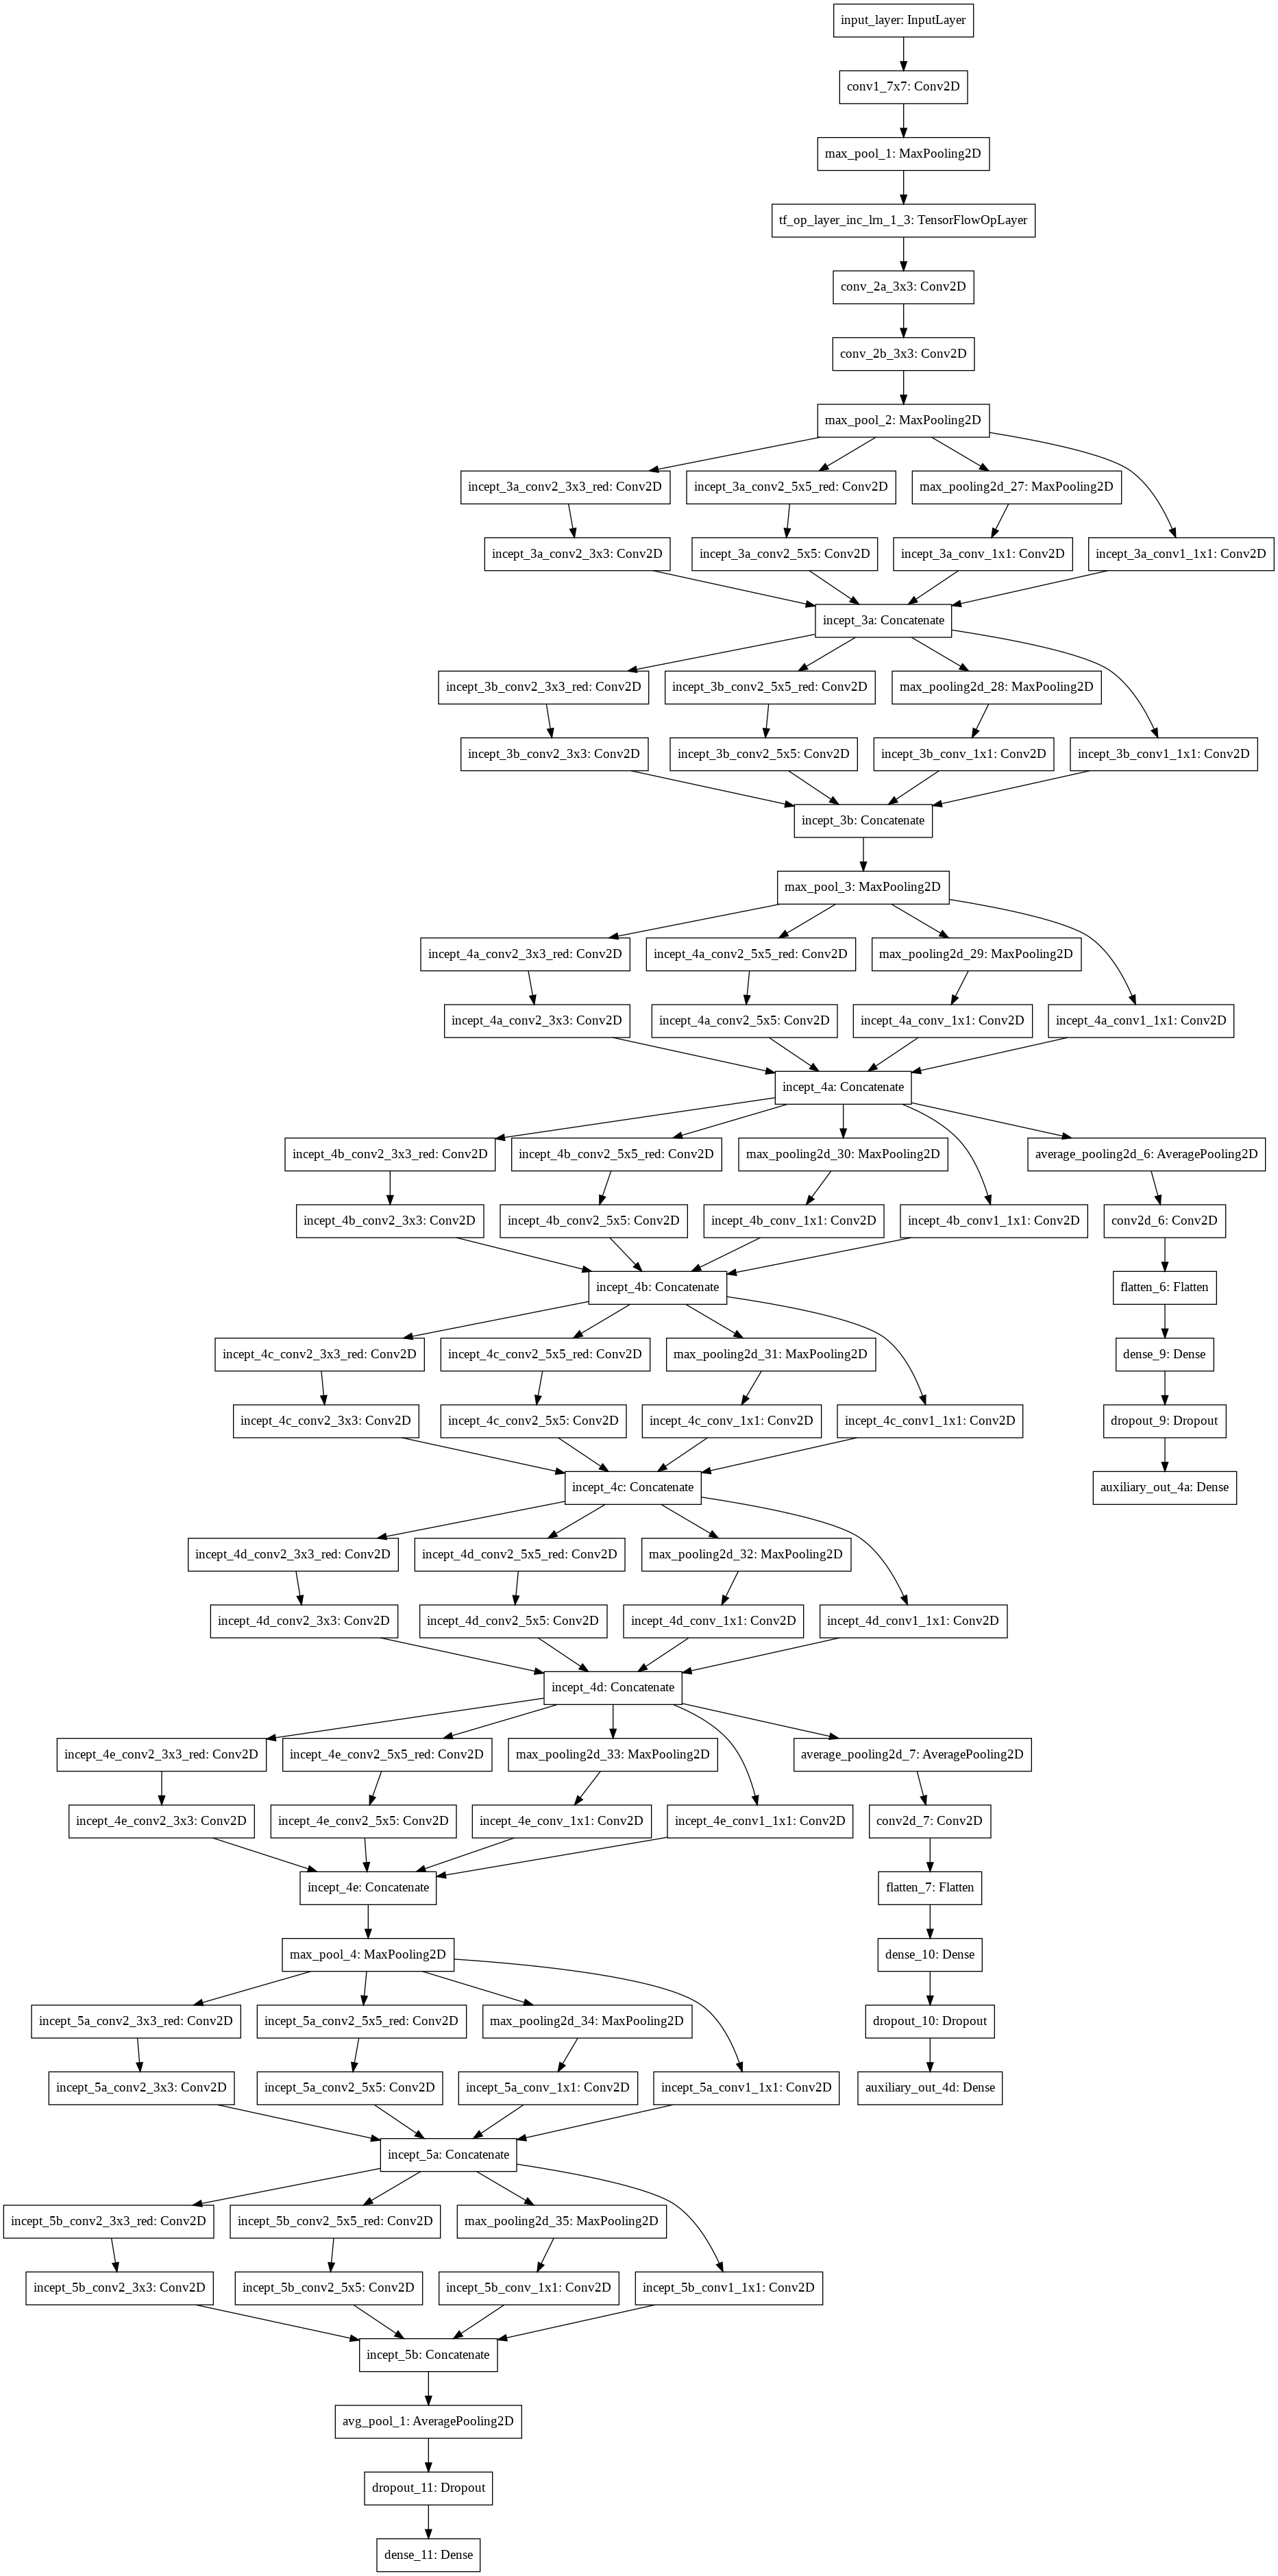

In [0]:
utils.plot_model(gn)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
ls

 1
'2.3 ANSWERS FROM LAB WITH PYTHON VERSION 2.gdoc'
'2Φωτογραφία από Xenia'
'Adv DL project.gsheet'
 AI_A1.gdoc
'AI - A3 NOTES.gdoc'
 Colab_Deep_Learning_Lab3/
'Colab Notebooks'/
 IMG_20181208_232057_147.jpg
 jar_files.zip
'KTH Courses.gsheet'
 KTH_GENERAL/
 Lab1.rar
 lab2/
 lab2_id2223.ipynb
'MONTHLY EXPENSES.gdoc'
'Movies (have seen).gdoc'
'Personal Questions - Cambridge.gdoc'
 project_poster_BundleSearch.gslides
 recommendations/
 REFERENCES.gdoc
 scalable_lab_for_tf.ipynb
'Station C1-5CDs'/
 SUPERMARKET.gdoc
 tamos_past_exams/
 xenia_ADL_project_1/


In [0]:
import re
import os
import pickle

from PIL import Image

import numpy as np
import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
        preprocess_input

from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, \
        Embedding, LSTM


from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.keras.engine import training
from tensorflow.python.data.ops.dataset_ops import PrefetchDataset

from typing import List, Tuple
import tqdm
from tqdm import tqdm
import sys
import nltk
from nltk import bleu_score

In [0]:
def get_image_names(f_name: str) -> List:
    """Gets a list of image names

    Args:
        f_name: File name/Path

    Returns:
        img_names: List of image names
    """
    with open(f_name, 'r') as f:
        img_names = f.read().splitlines()

    img_names = ["./lab2/flickr8k/Flickr_Data/Images/" + name for name in img_names]

    # Sort the images and make sure that the list is unique
    img_names = sorted(set(img_names))

    return img_names

def get_all_captions(f_name: str) -> dict:
    """ Store all captions in a dictionary

    Args:
        f_name: Path of file containing all captions

    Returns:
        all_captions: Dictionary where keys are image names and values are
                      captions
    """
    with open(f_name, 'r') as f:
        caption_file = f.read().splitlines()

    # Store captions in a dictionary
    all_captions = {}

    for line in caption_file:
        name = re.search("^.*?jpg", line).group(0)
        caption = "<start> " +  re.search("\t(.*)", line).group(0)[1:] + " <end>"

        if name in all_captions.keys():
            all_captions[name].append(caption)
        else:
            all_captions[name] = [caption]

    return all_captions

In [0]:
def preprocess_image(img_path: str) -> Tuple[EagerTensor, str]:
    """Load and preprocess an image from path and preprocess

    Args:
        img_path: Image path

    Returns:
        img: The preprocessed image
    """
    # Read image from path as TensorFlow tensor
    img = tf.io.read_file(img_path)

    # Tell TensorFlow that the image is RGB
    img = tf.image.decode_jpeg(img, channels=3)

    # The default input shape of InceptionV3 is (299, 299, 3)
    img = tf.image.resize(img, (299, 299))

    # Default InceptionV3 image processing
    img = preprocess_input(img)

    return img, img_path

def extract_img_features(img_names: List, feat_extractor):
    """Extract features from list of images and store them in .npy matrices

    Args:
        img_names: List of image names
    """
    print("Starting image preprocessing...")
    # Check whether image needs preprocessing and feature extraction
    unprocessed_imgs = []
    for img in img_names:
        # The image might have been processed already
        if not os.path.isfile(img + ".npy"):
            unprocessed_imgs.append(img)

    # Only start preprocessing and feature extraction process if
    # unprocessed_imgs is not empty
    if unprocessed_imgs:
        # Create a data set from the images
        imgs = tf.data.Dataset.from_tensor_slices(unprocessed_imgs)

        # Preprocess each image in batches of 8
        img_batches = imgs.map(preprocess_image, num_parallel_calls=
                tf.data.experimental.AUTOTUNE).batch(8)

        for img, path in tqdm(img_batches):
            # Extract features for each batch of images
            batch_feat = feat_extractor(img)
            batch_feat = tf.reshape(batch_feat, (batch_feat.shape[0], -1,
            batch_feat.shape[3]))

            # Store the feature matrices in ./flickr8k/imgs/
            for bf, p in zip(batch_feat, path):
                feat_path = p.numpy().decode("utf-8")
                np.save(feat_path, bf.numpy())
    print(("Finished image preprocessing! "
        f"Processed {len(unprocessed_imgs)} images."))

def init_feat_extract_inception_v3() -> training.Model:
    """Initialize InceptionV3 as feature extraction model

    Returns:
        feat_extract_model: The feature extraction model based on weights
                            learnt on ImageNet
    """
    # Load the pretrained InceptionV3 network with weights from trianing on
    # ImageNet
    incv3 = InceptionV3(include_top=False, weights='imagenet')

    # Create a default model input
    model_input = incv3.input

    # We want the penultimate layer to be the last layer of our feature
    # extraction CNN. Note that the size of this layer is 8*8*2048.
    model_output = incv3.layers[-1].output

    # Define the feature extraction model
    feat_extract_model = Model(model_input, model_output)

    return feat_extract_model 

In [0]:
def preprocess_captions(img_names_training: List, all_captions:
        dict, k: int) -> Tuple[Tokenizer, np.ndarray]:
    """Preprocess all captions

    Args:
        img_names: Image names from the training data set
        all_captions: Captions of the complete data set
        k: Maximum number of words in our vocabulary

    Returns:
        tokenizer: The tokenizer fit on the captions of the training data set
        seqs: All tokenized captions in the training data set
    """
    # Split image names to remove everything from path except file name
    img_names = [img.split("/")[-1] for img in img_names_training]

    # Filter all_captions for the training set
    captions = {k: all_captions[k] for k in img_names if k in
            all_captions.keys()}

    # Extract all individual captions for the training set
    captions = [cap for img in img_names for cap in captions[img]]

    if os.path.isfile("./tokenizer.pkl"):
        # Load the tokenizer
        print("Loading tokenizer...")
        with open('tokenizer.pkl', 'rb') as f:
            tokenizer = pickle.load(f)
    else: 
        # Define the tokenizer
        tokenizer = Tokenizer(num_words=k, oov_token="<unk>",
                filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

        # Specificy word indexing
        tokenizer.word_index["<pad>"] = 0
        tokenizer.index_word[0] = "<pad>"

        # Fit the tokenizer on all captions in the training set
        print("Fitting tokenizer...")
        tokenizer.fit_on_texts(captions)

        # Save the tokenizer
        with open('tokenizer.pkl', 'wb') as f:
            print("Saving tokenizer...")
            pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

    # Create tokenized sequences for all captions
    seqs = tokenizer.texts_to_sequences(captions)

    # Pad the sequences s.t. they become of the same size
    seqs = pad_sequences(seqs, padding="post")

    return tokenizer, seqs

In [0]:
class Encoder(Model):
    """Subclass of tf.keras.Model: Encoder"""
    def __init__(self, embedding_dim: int):
        """Class constructor

        Args:
            embedding_dim: Dimensionality of the image embedding
        """
        super(Encoder, self).__init__()

        self.dense = Dense(embedding_dim, activation="relu")
        self.dropout = Dropout(0.5)
        self.b_norm = BatchNormalization()

    def call(self, x: tf.Tensor, training: bool=True):
        """Call function of the encoder model

        Args:
            x: Input tensor

        Returns:
            x: Output tensor
        """
        if training:
            x = self.dropout(x)

        x = self.dense(x)
        x = self.b_norm(x)

        # After the dense layer, the shape of x is: # (batch_size, 64,
        # embedding_dim). It should be of the same dimension as the text
        # embedding, which is (1, 1, embedding_dim)
        x = tf.expand_dims(tf.reduce_sum(x, axis=1), 1)

        return x

In [0]:
class Decoder(Model):
    """Subclass of tf.keras.Model: Decoder"""
    def __init__(self, embedding_dim: int, units: int, vocab_size: int):
        """Class constructor

        Args:
            embedding_dim: Dimensionality of the image embedding
            units:
            vocab_size:
        """
        super(Decoder, self).__init__()
        
        self.units = units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(units=units, return_sequences=True, return_state=True,
                name="lstm")
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, x, img_feats: tf.Tensor, lstm_state: List[tf.Tensor]=None,
            training: bool=True, time_step: int=0):
        """Call function of the encoder model

        Args:
            x: Input tensor
            img_feats: Feature embedding of the input image
            lstm_state: Initital state of the LSTM based on previous time step
            training: Whether the current phase is training
            it: Specify the current timestep
        
        Returns:
            x: Output tensor
        """
        x = self.embedding(x)

        # Only input the image features to the LSTM during the first pass
        if time_step == 0:
            _, h_state, c_state = self.lstm(img_feats)
            output, h_state, c_state = self.lstm(x,
                    initial_state=[h_state, c_state])
        else:
            output, h_state, c_state = self.lstm(x, initial_state=lstm_state)

        # Store the LSTM's hidden state and cell state in a list
        lstm_state = [h_state, c_state]

        # Because of return_sequences = True outut has three dimensions
        # (batch_size, time_step, output_units), which is needed since we are
        # stacking LSTMs. However, we want to return a 2D array of shape
        # (batch_Size, output_units)
        x = tf.reshape(output, (-1, output.shape[2]))

        # Pass the reshaped
        x = self.dense(x)

        return x, lstm_state

In [0]:
def load_img_features(img_name: str, cap: np.ndarray) -> Tuple[tf.Tensor,
        np.ndarray]:
    """Loads Numpy image features based on file name

    Args:
        img_name: Path to image file
        cap: Caption corresponding to image

    Returns:
        img: Tensor of image feature
        cap: Caption corresponding to image

    Note: We are passing cap, since this function is part of a lambda mapping
          function
    """
    img = np.load(img_name.decode("utf-8") + '.npy')

    return img, cap

def create_tf_dataset(img_names: List, seqs: np.ndarray, batch_size: int,
        buffer_size: int=8000):
    """Create a TensorFlow data set from a list of image names

    Args:
        img_names: List of image names
        seqs: Array of tokenized sequences corresponding to captions
        batch_size: Batch size

    Returns:
        dataset: TensorFlow data set partioned in batches of batch_size
    """
    # Create dataset form tensors
    dataset = tf.data.Dataset.from_tensor_slices((img_names, seqs))

    # Load the numpy files into the dataset
    dataset = dataset.map(lambda img, cap: tf.numpy_function(
        load_img_features, [img, cap], [tf.float32, tf.int32]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle the data set and create batches of size batch_size
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

def loss_function(real: tf.Tensor, pred: tf.Tensor) -> tf.Tensor:
    """Define the loss function

    Args:
        real: Real caption
        pred: Predicted caption

    Returns:
        loss: Loss
    """
    objective = SparseCategoricalCrossentropy(from_logits=True, reduction="none")

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = objective(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_mean(loss)

    return loss

@tf.function
def train_step(img, cap, encoder, decoder, optimizer, tokenizer):
    """Perform a single training step

    Args:
        img: Input image
        cap: Input (target) caption
        encoder: Encoder model
        decoder: Decoder model
        optimizer: Optimizer
        tokenizer: Tokenizer

    Returns:
        batch_loss: Batch loss
        total_loss: Total loss
    """
    batch_loss = 0

    # Define the decoder input -- tokenizer target caption
    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]] *
            cap.shape[0], 1)

    with tf.GradientTape() as tape:
        # Encode the image
        img_feats = encoder(img, training=True)

        # At the start the LSTM doesn't have a state yet
        lstm_state = None

        for i in range(1, cap.shape[1]):
            preds, lstm_state = decoder(dec_input, img_feats, lstm_state,
                    training=True, time_step=i-1)

            batch_loss += loss_function(cap[:, i], preds)

            dec_input = tf.expand_dims(cap[:, i], axis=1)

    total_loss = (batch_loss / int(cap.shape[1]))

    # Identify all trainable variables
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables

    # Compute the gradients of the trainable variables
    gradients = tape.gradient(batch_loss, trainable_vars)

    # Apply the gradients to the optimizer
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    return batch_loss, total_loss


def train(dataset: PrefetchDataset, epochs: int, encoder: Encoder,
        decoder: Decoder, optimizer: Adam, tokenizer: Tokenizer,
        num_steps: float):
    """Train the image captioning model

    Args:
        dataset: Training data set
        epochs: Number of training epochs
        encoder: Encoder model
        decoder: Decoder model
        optimizer: Optimizer
        tokenizer: Tokenizer
        num_steps: Number of training steps
    """
    ckpt_path = "./checkpoints"

    if not os.path.exists(ckpt_path):
        os.makedirs(ckpt_path)

    # Create a checkpoint
    ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder,
            optimizer=optimizer)

    # Pass the checkpoint to the checkpoint manager
    ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=5)

    start_epoch = 0
    if ckpt_manager.latest_checkpoint:
        print("Loading checkpoint...")
        start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
        ckpt.restore(ckpt_manager.latest_checkpoint)#.assert_consumed()
        print("Latest checkpoint restored!")

    print(f"Start epoch: {start_epoch}")
    for epoch in range(start_epoch, epochs):
        total_loss = 0

        for (batch, (img, cap)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img, cap, encoder, decoder,
                    optimizer, tokenizer)
            total_loss += t_loss

        print("Saving a checkpoint...")
        ckpt_manager.save(checkpoint_number=epoch)

        print("Epoch {} - Loss {:.6f}".format(epoch + 1, total_loss/num_steps))

In [0]:
def evaluate(img: str, feat_extract_model: training.Model,
        tokenizer: Tokenizer, encoder: Encoder, decoder: Decoder,
        max_length: int=20, eval_type: str="beam", beam_size=1):
    """Predict a caption for a specific image using naive sequence sampling

    Args:
        img: Name of input image for evaluation
        feat_extract_model: Image feature extraction model
        tokenizer: Tokenizer
        encoder: Encoder model
        decoder: Decoder model
        max_length: Maximum length of the resulting caption
        eval_type: Either 'beam' or 'greedy' to specify the type of evaluation
        beam_size: Size of the beam if eval_type=='beam"

    Return:
        caption: Final caption
    """
    img = tf.expand_dims(preprocess_image(img)[0], 0)
    img = feat_extract_model(img)
    img = tf.reshape(img, (img.shape[0], -1,
        img.shape[3]))

    # Encode the image to extract features
    img_feats = encoder(img)

    if eval_type == "greedy":
        print("Starting greedy search...")
        # Define the initial decoder input
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

        # The LSTM does not have a state at first
        lstm_state = None

        caption = []
        for i in range(max_length):
            # Predict next word id using :STM
            predictions, lstm_state = decoder(dec_input, img_feats, lstm_state,
                    time_step=i)

            # Predcict the id
            predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
            caption.append(tokenizer.index_word[predicted_id])

            if tokenizer.index_word[predicted_id] == '<end>':
                return " ".join(caption[:-1])

            dec_input = tf.expand_dims([predicted_id], 0)

        caption = " ".join(caption[:-1])
      
    elif eval_type == "beam":
        print(f"Starting beam search with beam size {beam_size}...")
        # Initialize the result (ids, decoder input, probability, lstm state)
        cap = [tokenizer.word_index["<start>"]]
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
        lstm_state = None
        prob = 0.0

        result = [[cap, dec_input, prob, lstm_state]]

        for i in range(max_length):
            # Track a temporary result
            temp_res = []

            # Iterate over each word in the current result
            for r in result:
                dec_input, lstm_state = r[1], r[3]
                predictions, lstm_state = decoder(dec_input, img_feats,
                        lstm_state, time_step=i)

                # Obtain the indices of the top-beamsize predictions
                predicted_ids = predictions[0].numpy().argsort() \
                        [-beam_size:][::-1]

                # Loop over all predicted ids
                for i in predicted_ids:
                    # Obtain the current partial caption and probability
                    cap, prob = r[0][:], r[2]

                    # Add the index to the current partial capption
                    cap.append(i)
                    # Add the probability of i to prob
                    prob += predictions[0].numpy()[i]

                    # Add the updated partial caption and probability to the
                    # temporary result
                    dec_input = tf.expand_dims([i], 0)
                    temp_res.append([cap, dec_input, prob, lstm_state])

            # Update result by the temporary result
            result = temp_res

            # Sort the result based on the probabilities and only keep the
            # top-beamsize partial captions
            result = sorted(result, reverse=True, key=lambda l: l[2])
            result = result[:beam_size]

        # Obtain the final best result
        caption = result[0][0]

        caption = [tokenizer.index_word[i] for i in caption][1:]
        caption = " ".join(caption)

        try:
            caption = caption.split("<end>", 1)[:-1][0][:-1]
        except:
            pass
    else:
        raise ValueError("Input argument <eval_type> has to be either " +
                  "'beam' or 'greedy'")

    return caption  

In [47]:
batch_size = 64

# Get the train image names
train_image_names = get_image_names(
        "./lab2/flickr8k/Flickr_Data/text/Flickr_8k.trainImages.txt")

# Initialize the feature extraction model (InceptionV3)
feat_extract_model = init_feat_extract_inception_v3()

# Extract features from the images
extract_img_features(train_image_names, feat_extractor=feat_extract_model)

# Get captions in the whole data set
all_captions = get_all_captions("./lab2/flickr8k/Flickr_Data/text/Flickr8k.token.txt")

# Fit a tokenizer on the training data with vocabulary of length k and
# find a tokenized sequences for each caption in the training data set
tokenizer, train_seqs = preprocess_captions(train_image_names,
        all_captions, k=5000)

# Duplicate each image name 5 times
train_image_names = [name for name in train_image_names
        for _ in range(5)]

# Create TensorFlow dataset
dataset = create_tf_dataset(train_image_names, train_seqs,
        batch_size=batch_size)

# Initialize the encoder and decoder
encoder = Encoder(embedding_dim=256)
decoder = Decoder(embedding_dim=256, units=512,
        vocab_size=len(tokenizer.word_index)+1)

# Instantiate the optimizer
optimizer = Adam()

# Calculate number of training steps
num_steps = len(train_image_names) / batch_size

# Train the model for 50 epochs
# train(dataset, 50, encoder, decoder, optimizer, tokenizer, num_steps)

Starting image preprocessing...


750it [34:44,  2.73s/it]


Finished image preprocessing! Processed 6000 images.
Fitting tokenizer...
Saving tokenizer...


In [0]:
# Based on the official tutorial: https://www.nltk.org/_modules/nltk/translate/bleu_score.html

def compute_bleu_score(predicted_output, true_output, n_grams="3-gram"):
    if n_grams == "1-gram":
        weights = [1.0]
    elif n_grams == "2-gram":
        weights = [1./2., 1./2.]
    elif n_grams == "3-gram":
        weights = [1./3., 1./3., 1./3.]
    elif n_grams == "4-gram":
        weights = [1./4., 1./4., 1./4., 1./4.]
    else:
        print("Provide an accepted mode. Choose from: 1-gram, 2-gram, 3-gram, 4-gram.")
        sys.exit()
        
    return bleu_score.sentence_bleu([predicted_output], true_output, weights=weights)



In [0]:
# Suppress warnings
tf.get_logger().setLevel('ERROR')

# Get the test image names
test_image_names = get_image_names(
        "./lab2/flickr8k/Flickr_Data/text/Flickr_8k.testImages.txt")

# Initialize the feature extraction model (InceptionV3)
feat_extract_model = init_feat_extract_inception_v3()

print("Loading tokenizer...")
with open('./lab2/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
print("Loaded tokenizer!")

# Initialize the encoder and decoder
encoder = Encoder(embedding_dim=256)
decoder = Decoder(embedding_dim=256, units=512,
        vocab_size=len(tokenizer.word_index)+1)

# Instantiate the optimizer
optimizer = Adam()

# Load the latest checkpoint
ckpt_path = "./lab2/checkpoints"

# Create a checkpoint
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder,
        optimizer=optimizer)

# Pass the checkpoint to the checkpoint manager
ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    print("Loading checkpoint...")
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!")

bleu_score_1_list = []
bleu_score_2_list = []
bleu_score_3_list = []
bleu_score_4_list = []

for i in range(11, 20):
    # Evaluate the model
    caption = evaluate(test_image_names[i], feat_extract_model, tokenizer,
            encoder, decoder)

    # Print the predicted caption
    print(f"Caption: {caption}")
    display(Image.open(test_image_names[i]))

    # Compute blue-scores
    blue_1 = compute_bleu_score(caption, all_captions[i], mode="1-gram")
    bleu_score_1_list.append()
    print("Blue score 1: ", blue_1)

    blue_2 = compute_bleu_score(caption, all_captions[i], mode="2-gram")
    bleu_score_2_list.append()
    print("Blue score 2: ", blue_2)

    blue_3 = compute_bleu_score(caption, all_captions[i], mode="3-gram")
    bleu_score_3_list.append()
    print("Blue score 3: ", blue_3)

    blue_4 = compute_bleu_score(caption, all_captions[i], mode="4-gram")
    bleu_score_4_list.append()
    print("Blue score 4: ", blue_4)